# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join

# 1. Reading the results

We read the results from text files into Pandas DataFrames for analysis.

In [2]:
# Read all results from txt files
# Parameter Setting (ACO & CLu): evaporation-factor/erasure-probability

parameter_e_path = "./parameter_tuning/"
parameter_e_files = [f for f in listdir(parameter_e_path) if isfile(join(parameter_e_path, f))]

column_names = ["Data-set", "Size", "Algorithm", "Support", "Run-time", "Cluster-time", "Patterns", "Pattern-count", "TP", "TN", "FP", "FN", "Support-error", "E"]
df_pe = pd.DataFrame(columns = column_names)

for file in parameter_e_files:
    f_path = join(parameter_e_path,file)
    try:
        res = pd.read_csv(f_path, names=["A","B"], sep = ':', header=None, engine='python')
    except Exception:
        print(f_path)
    
    run = float(res['B'][0][0:6]) # run-time
    # mem = str(res['B'][1]) # memory
    alg = str(res['B'][1]) # algorithm
    att = int(res['B'][2]) # number of attributes in the data set
    size = int(res['B'][3])  # data set size
    evp = float(res['B'][4]) # evaporation-factor / erasure-probability
    # mit = int(res['B'][5]) # maximum iteraction count
    sup = float(res['B'][6]) # minimum support
    pat = int(res['B'][8]) # patterns        
    
    if alg == " Clu-GRAD (v2.0)":
        clu = float(res['B'][9][0:6]) # cluster-time
        
        # Fetch patterns to test accuracy
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        miss = 0
        gps = [""] * pat
        errs = np.zeros(pat)  #[0.0] * pat
        gp_pos = res.loc[res['A'] == 'Comparison '].index[0] + 1 # 1st position
        for i in range(pat):
            pos = i + gp_pos
            sups = str(res['B'][pos])
            gps[i] = [res['A'][pos], sups]
            sup_arr = sups.split(", ")
            est_sup = float(sup_arr[0])
            true_sup = float(sup_arr[1])
            
            # Compute TP, TN, FP, FN
            if (est_sup >= sup) and (true_sup >= sup):
                tp += 1
                temp_err = (true_sup - est_sup) / true_sup
                errs[i] = abs(temp_err)
            elif ((est_sup >= 0) and (est_sup < sup)) and (true_sup < sup):
                tn += 1
                if true_sup > 0:
                    temp_err = (true_sup - est_sup) / true_sup
                    errs[i] = abs(temp_err)
            elif (est_sup >= sup) and (true_sup < sup):  # less than support or -1
                fp += 1
                miss += 1
            elif ((est_sup > 0) and (est_sup < sup)) and (true_sup >= sup):
                fn += 1
                miss += 1
            # if true_sup > 0:
            #    temp_err = (true_sup - est_sup) / true_sup
            #    errs[i] = abs(temp_err)
            # else:
            #    miss += 1
        # print(errs)
        # error_rate = errs.mean()
        actual_errs = errs[np.nonzero(errs)]
        if actual_errs.size > 0:
            error_rate = actual_errs.mean()
        else:
            error_rate = 0
    else:
        gps = [""] * pat
        gp_pos = res.loc[res['A'] == 'Pattern '].index[0] + 1 # 1st position
        for i in range(pat):
            pos = i + gp_pos
            gps[i] = [res['A'][pos], float(res['B'][pos])]
        clu = 0
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        miss = 0
        error_rate = 0
    if att == 10:
        col = "BCR"
    elif att == 15:
        col = "AQY"
    elif att == 98:
        col = "C2K"
    elif att == 170:
        col = "APS"
    else:
        col = ""
        
    # df_pe = df_pe.append({"Data-set": col, "Size": size, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Patterns":gps, "Pattern-count":pat, "Misclustered-patterns":miss, "Support-error":error_rate, "E": evp}, ignore_index=True)
    df_pe = pd.concat([df_pe, pd.DataFrame({"Data-set": col, "Size": size, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Patterns":gps, "Pattern-count":pat, 
                                            "TP":tp, "TN":tn, "FP": fp, "FN": fn, "Support-error":error_rate, "E":evp})])

df_pe['Algorithm'].replace({' Clu-GRAD (v1.9)' : 'CluGRAD'}, inplace=True)
df_pe['Algorithm'].replace({' ACO-GRAANK (v4.0)' : 'ACoGRAD'}, inplace=True)
# df_pe

In [7]:
# Accuracy Performance of Clustering Algorithms used in Clu-GRAD

performance_path = "./performance_v2/"
performance_files = [f for f in listdir(performance_path) if isfile(join(performance_path, f))]

column_names = ["Data-set", "Size", "Features", "Cluster Algorithm", "Support", "Run-time", "Cluster-time", "Patterns", "Pattern-count", "TP", "TN", "FP", "FN", "Support-error", "E" ]
df_perf = pd.DataFrame(columns = column_names)
for file in performance_files:
    f_path = join(performance_path,file)
    try:
        res = pd.read_csv(f_path, names=["A","B"], sep = ':', header=None, engine='python')
    except Exception:
        print(f_path)
    
    run = float(res['B'][0][0:6]) # run-time
    # mem = str(res['B'][1]) # memory
    alg = str(res['B'][2]) # algorithm
    att = int(res['B'][3]) # number of attributes in the data set
    size = int(res['B'][4])  # data set size
    
    er_p = float(res['B'][5]) # evaporation-factor / erasure-probability
    # mit = int(res['B'][6]) # maximum iteraction count
    sup = float(res['B'][7]) # minimum support
    pat = int(res['B'][9]) # patterns
    # clu = float(res['B'][10][0:6]) # cluster-time
    clu = float(0)
    c_alg = str(res['B'][11]) # clustering algorithm
    
    # print(str(c_alg) + " " + str(pat))
        
    # Fetch patterns to test accuracy
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    miss = 0
    gps = [""] * pat
    errs = np.zeros(pat)  # [0.0] * pat
    gp_pos = res.loc[res['A'] == 'Comparison '].index[0] + 1 # 1st position
    for i in range(pat):
        pos = i + gp_pos
        sups = str(res['B'][pos])
        gps[i] = [res['A'][pos], sups]
        sup_arr = sups.split(", ")
        est_sup = float(sup_arr[0])
        true_sup = float(sup_arr[1])
        # Compute TP, TN, FP, FN
        if (est_sup >= sup) and (true_sup >= sup):
            tp += 1
            temp_err = (true_sup - est_sup) / true_sup
            errs[i] = abs(temp_err)
        elif ((est_sup >= 0) and (est_sup < sup)) and (true_sup < sup):
            tn += 1
            if true_sup > 0:
                temp_err = (true_sup - est_sup) / true_sup
                errs[i] = abs(temp_err)
        elif (est_sup >= sup) and (true_sup < sup):  # less than support or -1
            fp += 1
            miss += 1
        elif ((est_sup > 0) and (est_sup < sup)) and (true_sup >= sup):
            fn += 1
            miss += 1
        
        # if true_sup > 0:
        #    temp_err = (true_sup - est_sup) / true_sup
        #    errs[i] = abs(temp_err)
        # else:
        #    miss += 1
    actual_errs = errs[np.nonzero(errs)]
    if actual_errs.size > 0:
        error_rate = actual_errs.mean()
    else:
        error_rate = 0
    
    # Fetch patterns
    gps = [""] * pat
    gp_pos = res.loc[res['A'] == 'Pattern '].index[0] + 1 # 1st position
    for i in range(pat):
        pos = i + gp_pos
        gps[i] = [res['A'][pos], float(res['B'][pos])]
    
    if att == 10:
        col = "BCR"
    elif att == 15:
        col = "AQY"
    elif att == 98:
        col = "C2K"
    elif att == 21:
        if size == 15402:
            col = "DIR_15k"
        else:
            col = "DIR_8k"
    elif att == 170:
        col = "APS"
    else:
        col = ""

    df_perf = pd.concat([df_perf, pd.DataFrame({"Data-set": col, "Size": size, "Features": att, "Cluster Algorithm":c_alg, "Support":sup, "Run-time":run, "Cluster-time":clu, "Patterns":gps, "Pattern-count":pat, "TP":tp, "TN":tn, "FP": fp, "FN": fn, "Support-error":error_rate, "E":er_p})])

df_perf['Cluster Algorithm'].replace({' Fuzzy CMeans' : 'FCM'}, inplace=True)
df_perf['Cluster Algorithm'].replace({' PDC DP-Means' : 'PDM'}, inplace=True)
df_perf['Cluster Algorithm'].replace({' Standard KMeans' : 'SKM'}, inplace=True)
df_perf['Cluster Algorithm'].replace({' Persistable Clustering' : 'PC'}, inplace=True)
# df_perf


In [4]:
# Comparison Experiment (ACO & CLu & GRA)

compare_path = "./compare/"
compare_files = [f for f in listdir(compare_path) if isfile(join(compare_path, f))]

column_names = ["Data-set", "Size", "Features", "Algorithm", "Support", "Run-time", "Cluster-time", "Memory", "Patterns", "Pattern-count", "Misclustered-patterns", "Support-error", "E"]
df_comp = pd.DataFrame(columns = column_names)
for file in compare_files:
    f_path = join(compare_path,file)
    try:
        res = pd.read_csv(f_path, names=["A","B"], sep = ':', header=None, engine='python')
    except Exception:
        print(f_path)
    
    run = float(res['B'][0][0:6]) # run-time
    mem = str(res['B'][1]) # memory
    alg = str(res['B'][2]) # algorithm
    att = int(res['B'][3]) # number of attributes in the data set
    size = int(res['B'][4])  # data set size

    if alg == " GRAANK ":
        evp = 0
        # mit = 0
        sup = float(res['B'][5]) # minimum support
        pat = int(res['B'][7]) # patterns
    else:
        evp = float(res['B'][5]) # evaporation-factor / erasure-probability
        # mit = int(res['B'][6]) # maximum iteraction count
    
        sup = float(res['B'][7]) # minimum support
        pat = int(res['B'][9]) # patterns
        
    if alg == " Clu-GRAD (v1.9)":
        clu = float(res['B'][10][0:6]) # cluster-time
        
        # Fetch patterns to test accuracy
        miss = 0
        gps = [""] * pat
        errs = np.zeros(pat)  #[0.0] * pat
        gp_pos = res.loc[res['A'] == 'Comparison '].index[0] + 1 # 1st position
        for i in range(pat):
            pos = i + gp_pos
            sups = str(res['B'][pos])
            gps[i] = [res['A'][pos], sups]
            sup_arr = sups.split(", ")
            est_sup = float(sup_arr[0])
            true_sup = float(sup_arr[1])
            if true_sup > 0:
                temp_err = (true_sup - est_sup) / true_sup
                errs[i] = abs(temp_err)
            else:
                miss += 1
        error_rate = errs.mean()
    else:
        clu = 0
        miss = 0
        error_rate = 0
    
    # Fetch patterns
    gps = [""] * pat
    gp_pos = res.loc[res['A'] == 'Pattern '].index[0] + 1 # 1st position
    for i in range(pat):
        pos = i + gp_pos
        gps[i] = [res['A'][pos], float(res['B'][pos])]
    
    if att == 10:
        col = "BCR"
    elif att == 15:
        col = "AQY"
    elif att == 98:
        col = "C2K"
    elif att == 21:
        if size == 15402:
            col = "DIR_15k"
        else:
            col = "DIR_8k"
    elif att == 170:
        col = "APS"
    else:
        col = ""
    # df_comp = df_comp.append({"Data-set": col, "Size": size, "Features": att, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Memory":mem, "Patterns":gps, "Pattern-count":pat, "Misclustered-patterns":miss, "Support-error":error_rate, "E": evp}, ignore_index=True)
    df_comp = pd.concat([df_comp, pd.DataFrame({"Data-set": col, "Size": size, "Features": att, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Memory":mem, "Patterns":gps, "Pattern-count":pat, "Misclustered-patterns":miss, "Support-error":error_rate, "E": evp})])

df_comp['Algorithm'].replace({' Clu-GRAD (v1.9)' : 'CluGRAD'}, inplace=True)
df_comp['Algorithm'].replace({' ACO-GRAANK (v4.0)' : 'ACoGRAD'}, inplace=True)

# df_comp

# 2. Parameter Tuning 
## (Evaporation Factor/Erasure Probability)

We conduct an analysis to determine:

* The optimum max-iteration for estimating score-vectors for the Clu-GRAD algorithm.

* The optimum values for evaporation-factor (ACO-GRAD) and erasure-probability (CLu-GRAD).



In [33]:

data_sets = ['AQY', 'C2K', 'APS']
algorithms = ['CluGRAD']#, 'ACoGRAD', 'GRAANK']
evals_e = [0.25, 0.5, 0.75, 0.8, 0.9]

eval_data_e = []


# Only include these columns
df_res = df_pe[["Data-set", "Algorithm", "Support", "Run-time", "Cluster-time", "Pattern-count", "TP", "TN", "FP", "FN", "Support-error", "Patterns", 'E']]

for ds in data_sets:
    df1 = df_res.loc[df_res['Data-set'] == ds]

    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        # print(df1)
        for ev in evals_e:
            df3 = df2.loc[df2['E'] == ev]
            if not df3.empty:
                tp = df3['TP']
                tn = df3['TN']
                fp = df3['FP']
                fn = df3['FN']
                if tp.mean() > 0:
                    precision = tp.mean() / (tp.mean() + fp.mean())
                    recall = tp.mean() / (tp.mean() + fn.mean())
                    f_score = (2 * precision * recall) / (precision + recall)
                else:
                    precision = 0
                    recall = 0
                    f_score = 0
                # print(f_score)
                pat_arr = []
                for index,row in df3.iterrows():
                    # 10/100/1000 evaluations
                    pat_arr.append(row['Patterns'])
                    # print(pat_arr)
                eval_data_e.append([ds, alg, ev, df3['Pattern-count'].mean(), df3['Pattern-count'].std(), df3['TP'].mean(), df3['TP'].std(), df3['TN'].mean(), df3['TN'].std(), df3['FP'].mean(), df3['FP'].std(), df3['FN'].mean(), df3['FN'].std(), 
                                    df3['Support-error'].mean(), df3['Support-error'].std(), df3['Run-time'].mean(), df3['Run-time'].std(), f_score])
                       
df_data_2 = pd.DataFrame(data=eval_data_e, columns=['Dataset', 'Algorithm', 'EFactor/ EProbability', 'Patterns (mean)', 'Patterns (std)', 'TP (mean)', 'TP (std)', 'TN (mean)', 'TN (std)','FP (mean)', 'FP (std)','FN (mean)', 'FN (std)',
                                                    'Support-error (mean)', 'Support-error (std)', 'Run-time (mean)', 'Run-time (std)', 'F-Score'])

# df_data_2


* Show the plots

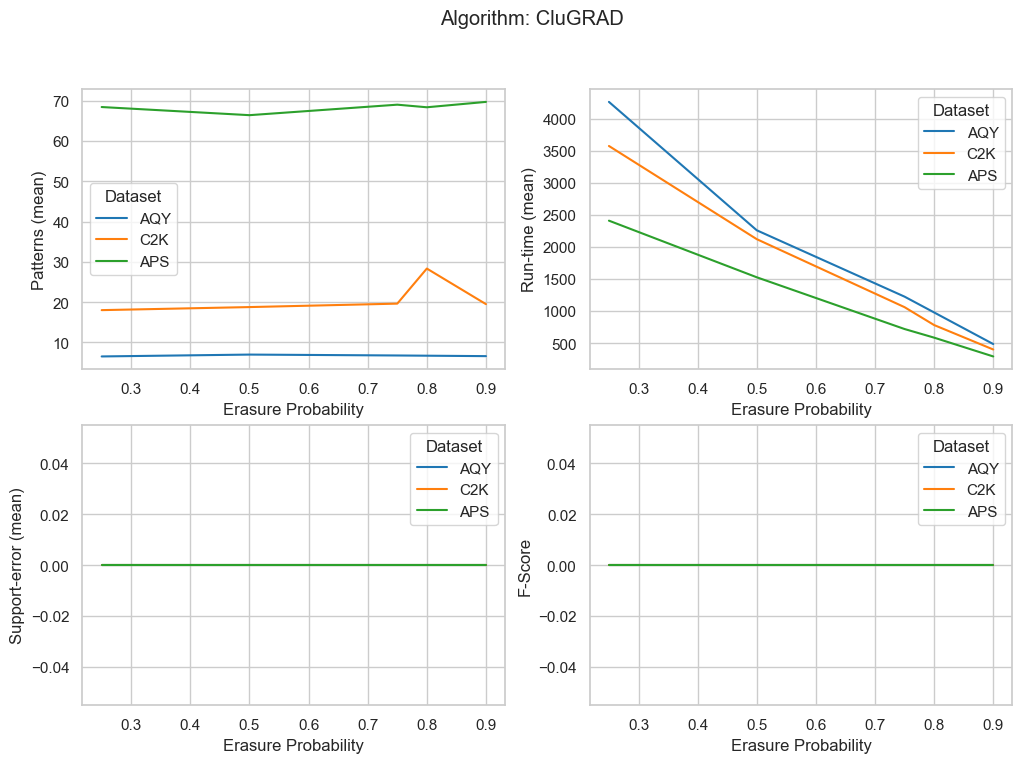

In [34]:

# Plotting the results 
sns.set_theme(style="whitegrid")

for alg in algorithms:
    df1 = df_data_2.loc[df_data_2['Algorithm'] == alg]
    
    if alg == 'ACoGRAD':
        x_label = "Evaporation Factor"
    elif alg == 'CluGRAD':
        x_label = "Erasure Probability"
    
    fig = plt.figure(figsize=(12,8))
    plt.subplot(2, 2, 1)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Patterns (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    plt.subplot(2, 2, 2)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Run-time (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    
    plt.subplot(2, 2, 3)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Support-error (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    
    plt.subplot(2, 2, 4)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="F-Score", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)

    fig.suptitle('Algorithm: ' + alg)
    # plt.savefig('parameter_tuning.png')
plt.show()

# 3. Analysis of Clu-GRAD Algorithm

## 3.1. Visualizing clusters using t-SNE 

We use the following acronyms:

* Standard-KMeans: SKM

* PDC-DP-Means: PDM

* Fuzzy-CMeans: FCM

* Persistable Clustering: PC


* We use t-SNE to visualize the clusters formed by the clustering algorithms used in Clu-GRAD. The t-SNE algorithm is a non-linear dimensionality reduction technique that is particularly well suited for embedding high-dimensional data into a space of two or three dimensions, which can then be visualized in a scatter plot. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence between the two distributions with respect to the locations of the points in the map. While the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this can be changed as appropriate. 

* It is important to mention that we use Standard KMeans (SKM) to take care of "hue" in the cluster diagrams.

In [5]:
# Visualize using t-SNE

# 1. SKM on data sets
df_bcr_skm_sapprox = pd.read_csv('./tsne_visual/BCR_SKM_SApprox.csv')
df_bcr_skm_ypred = pd.read_csv('./tsne_visual/BCR_SKM_YPred.csv')

df_aqy_skm_sapprox = pd.read_csv('./tsne_visual/AQY_SKM_SApprox.csv')
df_aqy_skm_ypred = pd.read_csv('./tsne_visual/AQY_SKM_YPred.csv')

df_c2k_skm_sapprox = pd.read_csv('./tsne_visual/C2K_SKM_SApprox.csv')
df_c2k_skm_ypred = pd.read_csv('./tsne_visual/C2K_SKM_YPred.csv')

df_dir_skm_sapprox = pd.read_csv('./tsne_visual/DIR_SKM_SApprox.csv')
df_dir_skm_ypred = pd.read_csv('./tsne_visual/DIR_SKM_YPred.csv')

df_aps_skm_sapprox = pd.read_csv('./tsne_visual/APS_SKM_SApprox.csv')
df_aps_skm_ypred = pd.read_csv('./tsne_visual/APS_SKM_YPred.csv')


# 2. PDM on data sets
df_bcr_pdm_sapprox = pd.read_csv('./tsne_visual/BCR_PDM_SApprox.csv')
df_bcr_pdm_ypred = pd.read_csv('./tsne_visual/BCR_PDM_YPred.csv')

df_aqy_pdm_sapprox = pd.read_csv('./tsne_visual/AQY_PDM_SApprox.csv')
df_aqy_pdm_ypred = pd.read_csv('./tsne_visual/AQY_PDM_YPred.csv')

df_c2k_pdm_sapprox = pd.read_csv('./tsne_visual/C2K_PDM_SApprox.csv')
df_c2k_pdm_ypred = pd.read_csv('./tsne_visual/C2K_PDM_YPred.csv')

df_dir_pdm_sapprox = pd.read_csv('./tsne_visual/DIR_PDM_SApprox.csv')
df_dir_pdm_ypred = pd.read_csv('./tsne_visual/DIR_PDM_YPred.csv')

df_aps_pdm_sapprox = pd.read_csv('./tsne_visual/APS_PDM_SApprox.csv')
df_aps_pdm_ypred = pd.read_csv('./tsne_visual/APS_PDM_YPred.csv')


# 3. FCM on data sets
df_bcr_fcm_sapprox = pd.read_csv('./tsne_visual/BCR_FCM_SApprox.csv')
df_bcr_fcm_ypred = pd.read_csv('./tsne_visual/BCR_FCM_YPred.csv')

df_aqy_fcm_sapprox = pd.read_csv('./tsne_visual/AQY_FCM_SApprox.csv')
df_aqy_fcm_ypred = pd.read_csv('./tsne_visual/AQY_FCM_YPred.csv')

df_c2k_fcm_sapprox = pd.read_csv('./tsne_visual/C2K_FCM_SApprox.csv')
df_c2k_fcm_ypred = pd.read_csv('./tsne_visual/C2K_FCM_YPred.csv')

df_dir_fcm_sapprox = pd.read_csv('./tsne_visual/DIR_FCM_SApprox.csv')
df_dir_fcm_ypred = pd.read_csv('./tsne_visual/DIR_FCM_YPred.csv')


# 4. PC on data sets
df_bcr_pc_sapprox = pd.read_csv('./tsne_visual/BCR_PC_SApprox.csv')
df_bcr_pc_ypred = pd.read_csv('./tsne_visual/BCR_PC_YPred.csv')

df_aqy_pc_sapprox = pd.read_csv('./tsne_visual/AQY_PC_SApprox.csv')
df_aqy_pc_ypred = pd.read_csv('./tsne_visual/AQY_PC_YPred.csv')

df_c2k_pc_sapprox = pd.read_csv('./tsne_visual/C2K_PC_SApprox.csv')
df_c2k_pc_ypred = pd.read_csv('./tsne_visual/C2K_PC_YPred.csv')

df_dir_pc_sapprox = pd.read_csv('./tsne_visual/DIR_PC_SApprox.csv')
df_dir_pc_ypred = pd.read_csv('./tsne_visual/DIR_PC_YPred.csv')

df_aps_pc_sapprox = pd.read_csv('./tsne_visual/APS_PC_SApprox.csv')
df_aps_pc_ypred = pd.read_csv('./tsne_visual/APS_PC_YPred.csv')


# print(df_bcr_skm_sapprox)
# print("\n")
# print(df_bcr_skm_sapprox.values)


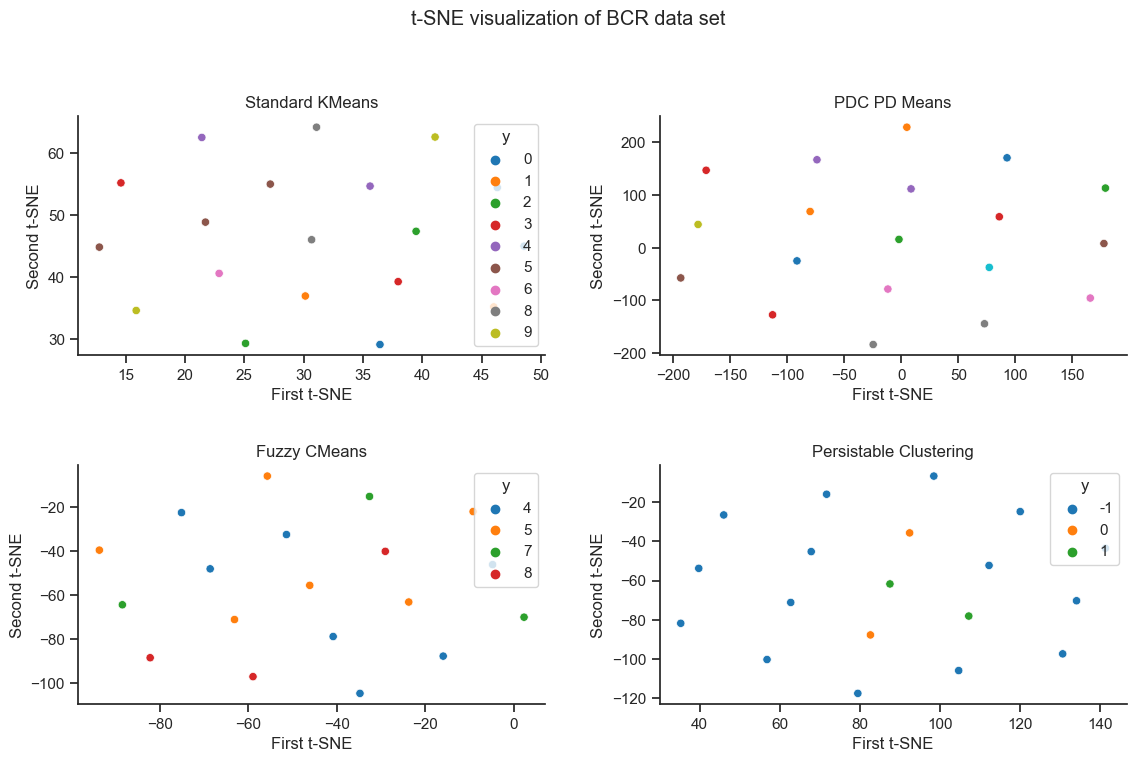

In [28]:
import warnings
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    tsne_1 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_1 = tsne_1.fit_transform(df_bcr_skm_sapprox.values)

    tsne_2 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_2 = tsne_2.fit_transform(df_bcr_pdm_sapprox.values)

    tsne_3 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_3 = tsne_3.fit_transform(df_bcr_fcm_sapprox.values)

    tsne_4 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_4 = tsne_4.fit_transform(df_bcr_pc_sapprox.values)

df1_tsne = pd.DataFrame(data=s_tnse_1, columns=['First t-SNE', 'Second t-SNE'])
df1_tsne['y'] = df_bcr_skm_ypred.values

df2_tsne = pd.DataFrame(data=s_tnse_2, columns=['First t-SNE', 'Second t-SNE'])
df2_tsne['y'] = df_bcr_pdm_ypred.values

df3_tsne = pd.DataFrame(data=s_tnse_3, columns=['First t-SNE', 'Second t-SNE'])
df3_tsne['y'] = df_bcr_fcm_ypred.values

df4_tsne = pd.DataFrame(data=s_tnse_4, columns=['First t-SNE', 'Second t-SNE'])
df4_tsne['y'] = df_bcr_pc_ypred.values


# print(df1_tsne)
#plt.figure(figsize=(6,4))
#plt.title("t-SNE SKM visualization of BCR data set")
#sns.scatterplot(
#    data=df_tsne, 
#    x='First t-SNE', 
#    y='Second t-SNE', 
#    hue='y', 
#    palette='tab10',
#    legend='brief')
# plt.show()



fig = plt.figure(figsize=(12,8))
fig.suptitle("t-SNE visualization of BCR data set")
plt.subplot(2, 2, 1)
sns.scatterplot(data=df1_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Standard KMeans')


plt.subplot(2, 2, 2)
sns.scatterplot(data=df2_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='PDC PD Means')
    
plt.subplot(2, 2, 3)
sns.scatterplot(data=df3_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Fuzzy CMeans')
    
plt.subplot(2, 2, 4)
sns.scatterplot(data=df4_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Persistable Clustering')

# plt.savefig('tsne_bcr.png')
fig.tight_layout(pad=2.5)
plt.show()

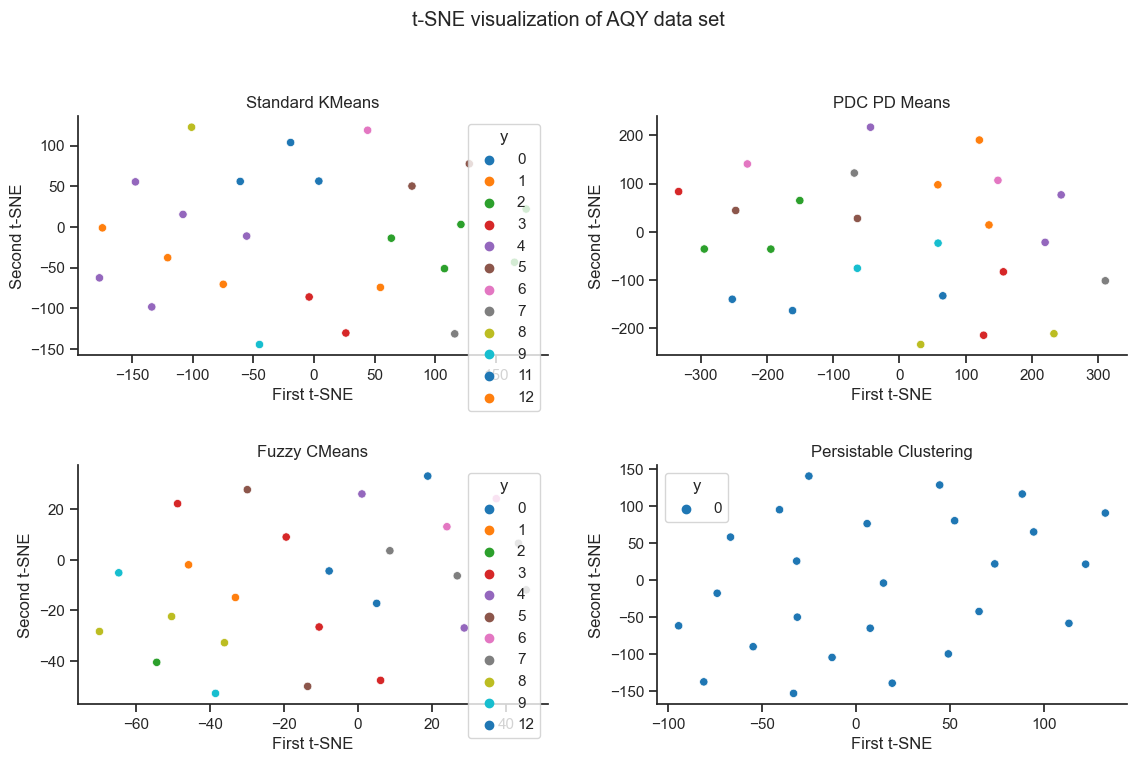

In [29]:
import warnings
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    tsne_1 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_1 = tsne_1.fit_transform(df_aqy_skm_sapprox.values)

    tsne_2 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_2 = tsne_2.fit_transform(df_aqy_pdm_sapprox.values)

    tsne_3 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_3 = tsne_3.fit_transform(df_aqy_fcm_sapprox.values)

    tsne_4 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_4 = tsne_4.fit_transform(df_aqy_pc_sapprox.values)

df1_tsne = pd.DataFrame(data=s_tnse_1, columns=['First t-SNE', 'Second t-SNE'])
df1_tsne['y'] = df_aqy_skm_ypred.values

df2_tsne = pd.DataFrame(data=s_tnse_2, columns=['First t-SNE', 'Second t-SNE'])
df2_tsne['y'] = df_aqy_pdm_ypred.values

df3_tsne = pd.DataFrame(data=s_tnse_3, columns=['First t-SNE', 'Second t-SNE'])
df3_tsne['y'] = df_aqy_fcm_ypred.values

df4_tsne = pd.DataFrame(data=s_tnse_4, columns=['First t-SNE', 'Second t-SNE'])
df4_tsne['y'] = df_aqy_pc_ypred.values


fig = plt.figure(figsize=(12,8))
fig.suptitle("t-SNE visualization of AQY data set")
plt.subplot(2, 2, 1)
sns.scatterplot(data=df1_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Standard KMeans')


plt.subplot(2, 2, 2)
sns.scatterplot(data=df2_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='PDC PD Means')
    
plt.subplot(2, 2, 3)
sns.scatterplot(data=df3_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Fuzzy CMeans')
    
plt.subplot(2, 2, 4)
sns.scatterplot(data=df4_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Persistable Clustering')

# plt.savefig('tsne_aqy.png')
fig.tight_layout(pad=2.5)
plt.show()

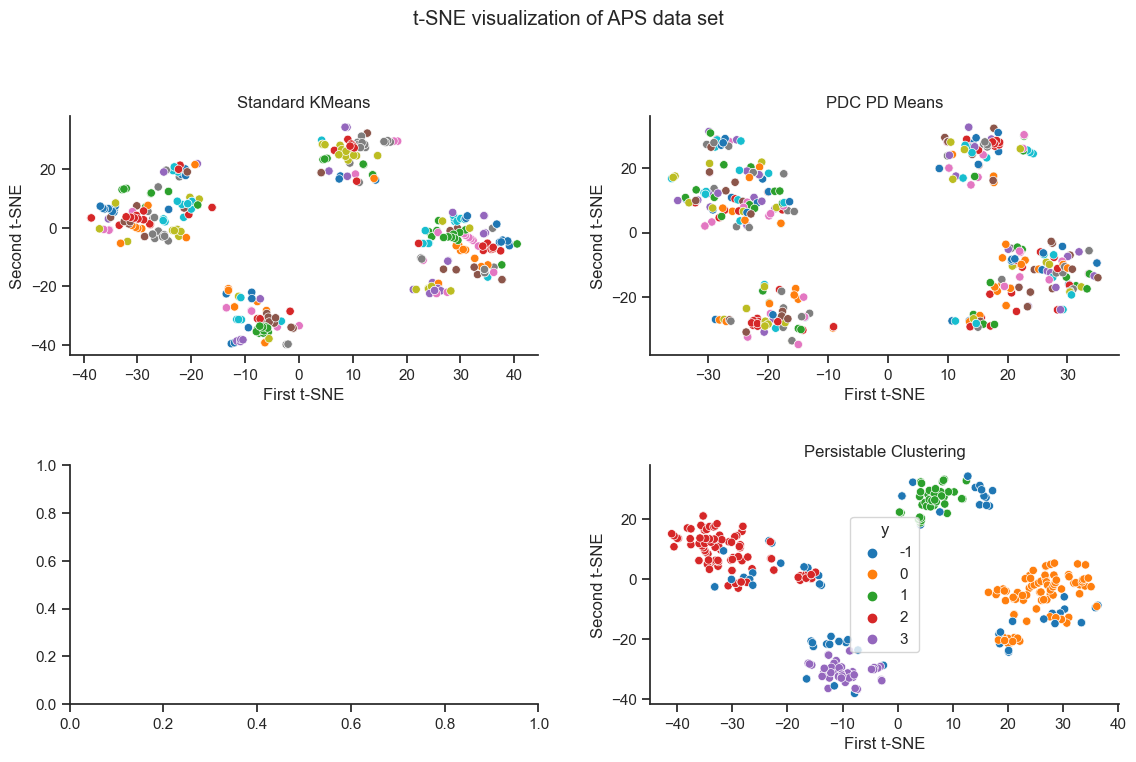

In [30]:
import warnings
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    tsne_1 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_1 = tsne_1.fit_transform(df_aps_skm_sapprox.values)

    tsne_2 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_2 = tsne_2.fit_transform(df_aps_pdm_sapprox.values)

    tsne_4 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_4 = tsne_4.fit_transform(df_aps_pc_sapprox.values)

df1_tsne = pd.DataFrame(data=s_tnse_1, columns=['First t-SNE', 'Second t-SNE'])
df1_tsne['y'] = df_aps_skm_ypred.values

df2_tsne = pd.DataFrame(data=s_tnse_2, columns=['First t-SNE', 'Second t-SNE'])
df2_tsne['y'] = df_aps_pdm_ypred.values

df4_tsne = pd.DataFrame(data=s_tnse_4, columns=['First t-SNE', 'Second t-SNE'])
df4_tsne['y'] = df_aps_pc_ypred.values


fig = plt.figure(figsize=(12,8))
fig.suptitle("t-SNE visualization of APS data set")
plt.subplot(2, 2, 1)
sns.scatterplot(data=df1_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='Standard KMeans')


plt.subplot(2, 2, 2)
sns.scatterplot(data=df2_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='PDC PD Means')
    
plt.subplot(2, 2, 3)
# sns.scatterplot(data=df3_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='Fuzzy CMeans')
    
plt.subplot(2, 2, 4)
sns.scatterplot(data=df4_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Persistable Clustering')

# plt.savefig('tsne_aqy.png')
fig.tight_layout(pad=2.5)
plt.show()

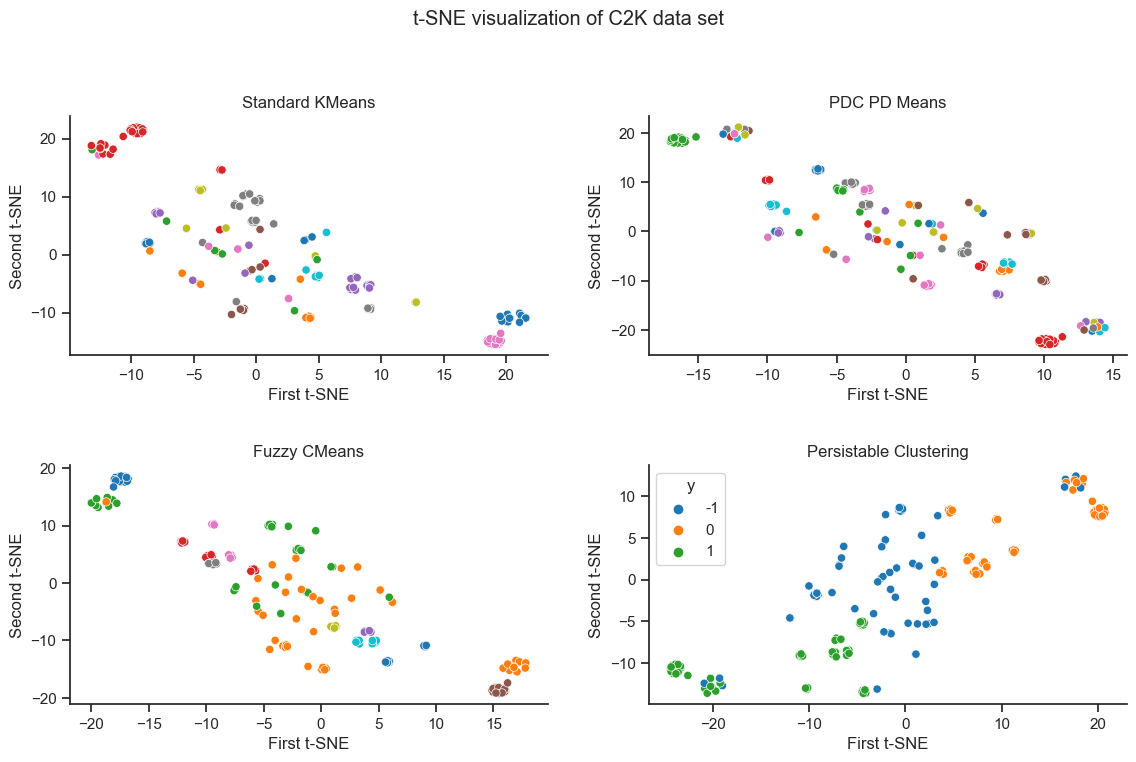

In [31]:
import warnings
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    tsne_1 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_1 = tsne_1.fit_transform(df_c2k_skm_sapprox.values)

    tsne_2 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_2 = tsne_2.fit_transform(df_c2k_pdm_sapprox.values)

    tsne_3 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_3 = tsne_3.fit_transform(df_c2k_fcm_sapprox.values)

    tsne_4 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_4 = tsne_4.fit_transform(df_c2k_pc_sapprox.values)

df1_tsne = pd.DataFrame(data=s_tnse_1, columns=['First t-SNE', 'Second t-SNE'])
df1_tsne['y'] = df_c2k_skm_ypred.values

df2_tsne = pd.DataFrame(data=s_tnse_2, columns=['First t-SNE', 'Second t-SNE'])
df2_tsne['y'] = df_c2k_pdm_ypred.values

df3_tsne = pd.DataFrame(data=s_tnse_3, columns=['First t-SNE', 'Second t-SNE'])
df3_tsne['y'] = df_c2k_fcm_ypred.values

df4_tsne = pd.DataFrame(data=s_tnse_4, columns=['First t-SNE', 'Second t-SNE'])
df4_tsne['y'] = df_c2k_pc_ypred.values


fig = plt.figure(figsize=(12,8))
fig.suptitle("t-SNE visualization of C2K data set")
plt.subplot(2, 2, 1)
sns.scatterplot(data=df1_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='Standard KMeans')


plt.subplot(2, 2, 2)
sns.scatterplot(data=df2_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='PDC PD Means')
    
plt.subplot(2, 2, 3)
sns.scatterplot(data=df3_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='Fuzzy CMeans')
    
plt.subplot(2, 2, 4)
sns.scatterplot(data=df4_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Persistable Clustering')

# plt.savefig('tsne_aqy.png')
fig.tight_layout(pad=2.5)
plt.show()

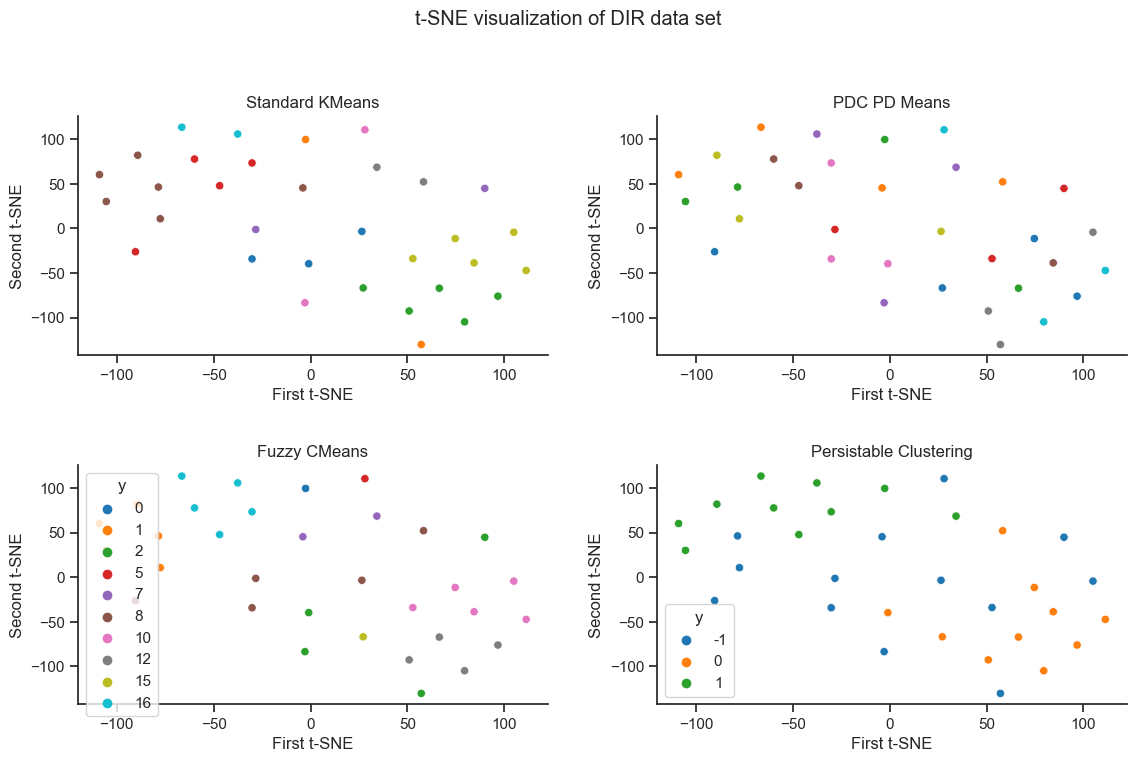

In [32]:
import warnings
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    tsne_1 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_1 = tsne_1.fit_transform(df_dir_skm_sapprox.values)

    tsne_2 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_2 = tsne_2.fit_transform(df_dir_pdm_sapprox.values)

    tsne_3 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_3 = tsne_3.fit_transform(df_dir_fcm_sapprox.values)

    tsne_4 = TSNE(n_components=2, perplexity=18, random_state=0)
    s_tnse_4 = tsne_4.fit_transform(df_dir_pc_sapprox.values)

df1_tsne = pd.DataFrame(data=s_tnse_1, columns=['First t-SNE', 'Second t-SNE'])
df1_tsne['y'] = df_dir_skm_ypred.values

df2_tsne = pd.DataFrame(data=s_tnse_1, columns=['First t-SNE', 'Second t-SNE'])
df2_tsne['y'] = df_dir_pdm_ypred.values

df3_tsne = pd.DataFrame(data=s_tnse_1, columns=['First t-SNE', 'Second t-SNE'])
df3_tsne['y'] = df_dir_fcm_ypred.values

df4_tsne = pd.DataFrame(data=s_tnse_1, columns=['First t-SNE', 'Second t-SNE'])
df4_tsne['y'] = df_dir_pc_ypred.values


fig = plt.figure(figsize=(12,8))
fig.suptitle("t-SNE visualization of DIR data set")
plt.subplot(2, 2, 1)
sns.scatterplot(data=df1_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='Standard KMeans')


plt.subplot(2, 2, 2)
sns.scatterplot(data=df2_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend=False).set(title='PDC PD Means')
    
plt.subplot(2, 2, 3)
sns.scatterplot(data=df3_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Fuzzy CMeans')
    
plt.subplot(2, 2, 4)
sns.scatterplot(data=df4_tsne, x='First t-SNE', y='Second t-SNE', hue='y', palette='tab10',legend='brief').set(title='Persistable Clustering')

# plt.savefig('tsne_aqy.png')
fig.tight_layout(pad=2.5)
plt.show()

## 3.2 Analyzing accuracy
We analyze the accuracy of various clustering algorithms. 

### 3.2.1 Confusion matrix comparison

In [8]:
data_sets = ['BCR', 'DIR_15k', 'C2K', 'APS', 'AQY']
algorithms = ['CluGRAD']
cluster_algorithms = ['SKM', 'PDM', 'FCM', 'PC']

df_acc = df_perf[["Data-set", "Cluster Algorithm", "Size", "Features", "E", "Run-time", "Cluster-time", "Pattern-count", "TP", "TN", "FP", "FN", "Support-error"]]
# print(df_acc)

data = []
data_plot = []
for ds in data_sets:
    df1 = df_acc.loc[df_acc['Data-set'] == ds]
    # print(df1)
    
    for alg in cluster_algorithms:
        df2 = df1.loc[df1['Cluster Algorithm'].str.contains(alg)]
        # print(alg + ': ' + str(df2['Size']))
        
        if not df2.empty:
            size = int(df2['Size'].median())
            features = int(df2['Features'].median())
            e_prob = float(df2['E'].median())
            r_time = df2['Run-time']
            c_time = df2['Cluster-time']
            p_count = df2['Pattern-count']
            tp =  df2['TP']
            tn = df2['TN']
            fp = df2['FP']
            fn = df2['FN']
            if tp.mean() > 0:
                precision = tp.mean() / (tp.mean() + fp.mean())
                recall = tp.mean() / (tp.mean() + fn.mean())
                f_score = (2 * precision * recall) / (precision + recall)
            else:
                precision = 0
                recall = 0
                f_score = 0
                
            s_error = df2['Support-error']
            data.append([ds, alg, size, features, e_prob, r_time.mean(), r_time.std(), c_time.mean(), c_time.std(), p_count.mean(), p_count.std(), 
                        tp.mean(), tp.std(), tn.mean(), tn.std(), fp.mean(), fp.std(), fn.mean(), fn.std(), s_error.mean(), s_error.std()])
            data_plot.append([ds, alg, size, features, e_prob, r_time.mean(), c_time.mean(), p_count.mean(), 
                            tp.mean(), tn.mean(), fp.mean(), fn.mean(), precision, recall, f_score, s_error.mean()])

df_data = pd.DataFrame(data=data, columns=['Data-set', 'Algorithm', 'Size', 'Features', 'E-Prob', 'Run-time (mean)', 'Run-time (std)', 'Cluster-time (mean)', 'Cluster-time (std)', 'Patterns (mean)', 'Patterns (std)',
                                           'TP (mean)', 'TP (std)', 'TN (mean)', 'TN (std)', 'FP (mean)', 'FP (std)', 'FN (mean)', 'FN (std)', 'Support-error (mean)', 'Support-error (std)'])
df_plot = pd.DataFrame(data=data_plot, columns=['Data-set', 'Algorithm', 'Size', 'Features', 'E-Prob', 'Run-time', 'Cluster-time', 'Patterns',
                                                'TP', 'TN', 'FP', 'FN', 'Precision', 'Recall', 'F-Score', 'Support-error'])
df_plot = df_plot.round(2)

df_data
df_plot[['Data-set', 'Algorithm', 'Patterns', 'TP', 'Precision', 'Recall', 'F-Score', 'Support-error']]

,Data-set,Algorithm,Patterns,TP,Precision,Recall,F-Score,Support-error
0,BCR,SKM,8.27,5.33,0.96,1.0,0.98,0.04
1,BCR,PDM,1.00,1.00,1.00,1.0,1.00,0.05
2,BCR,FCM,3.31,1.31,1.00,1.0,1.00,0.03
3,BCR,PC,2.56,0.33,1.00,1.0,1.00,0.01
4,DIR_15k,SKM,8.08,8.08,1.00,1.0,1.00,0.01
5,DIR_15k,FCM,7.36,5.00,1.00,1.0,1.00,0.01
6,DIR_15k,PC,3.00,0.00,0.00,0.0,0.00,0.00
7,C2K,SKM,28.51,10.49,0.55,1.0,0.71,0.03
8,C2K,PDM,18.71,0.71,0.07,1.0,0.13,0.07
9,C2K,FCM,10.69,0.00,0.00,0.0,0.00,0.00


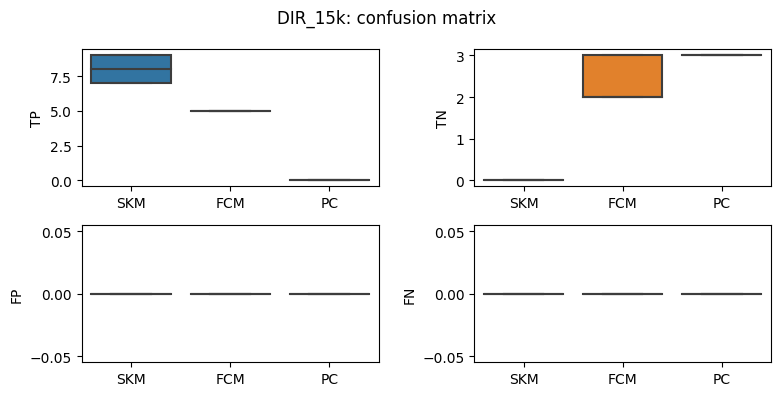

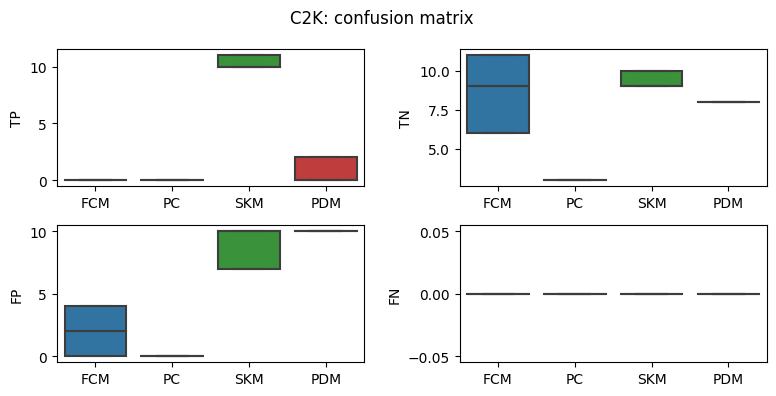

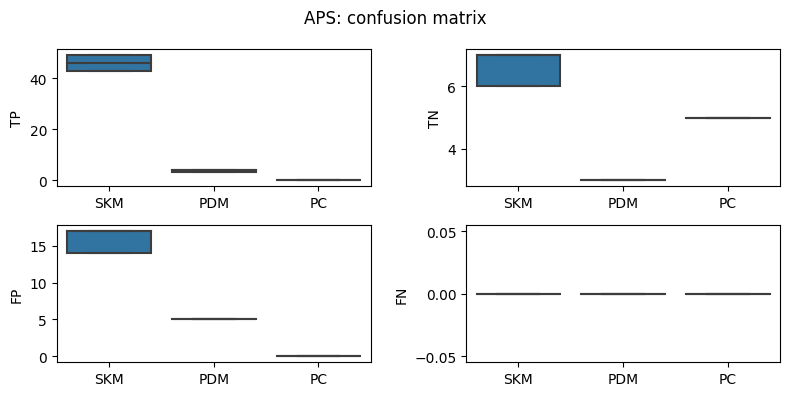

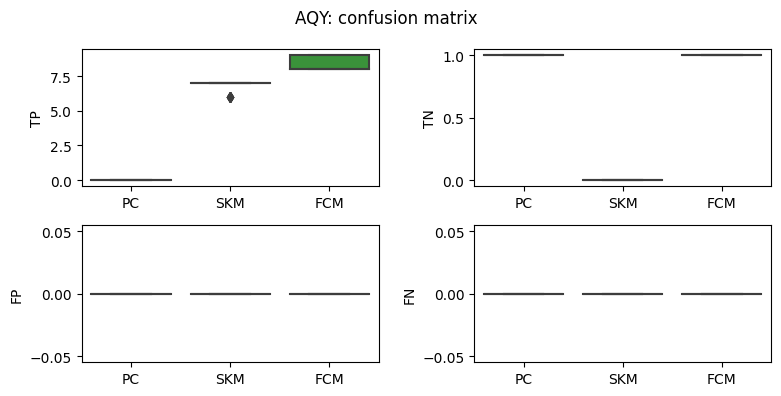

In [9]:
data_sets = ['DIR_15k', 'C2K', 'APS', 'AQY']
cluster_algorithms = ['SKM', 'PDM', 'FCM', 'PC']

data = []
data_plot = []
for ds in data_sets:
    df1 = df_acc.loc[df_acc['Data-set'] == ds]
    # print(df1)
    fig = plt.figure(figsize=(8,4))
    # fig.tight_layout() 
    fig.suptitle(ds + ': confusion matrix')
    
    plt.subplot(2, 2, 1)
    ax = sns.boxplot(x="Cluster Algorithm", y="TP", data=df1)
    ax.set(xlabel=None)  # remove the axis label
    
    plt.subplot(2, 2, 2)
    ax = sns.boxplot(x="Cluster Algorithm", y="TN", data=df1)
    ax.set(xlabel=None)  # remove the axis label

    plt.subplot(2, 2, 3)
    ax = sns.boxplot(x="Cluster Algorithm", y="FP", data=df1)
    ax.set(xlabel=None)  # remove the axis label
    
    plt.subplot(2, 2, 4)
    ax = sns.boxplot(x="Cluster Algorithm", y="FN", data=df1)
    ax.set(xlabel=None)  # remove the axis label
    #ax.set(ylim=(0, 50))
    
    plt.tight_layout() 
    # fig_name = "cmatrix_"+ds+".png"
    # plt.savefig(fig_name)
    plt.show()

## 3.3. Computational performance with K-Means

We analyze the performance and accuracy of the Clu-GRAD algorithm on 4 data sets.

In [16]:
data_sets = ['BCR', 'DIR_15k', 'DIR_8k', 'C2K', 'APS'] #, 'AQY']
algorithms = ['ACoGRAD', 'CluGRAD', 'GRAANK']


# Only include these columns
df_res = df_comp[["Data-set", "Algorithm", "Size", "Features", "Memory", "Run-time", "Cluster-time", "Pattern-count", "Misclustered-patterns", "Support-error"]]
# df_res1 = df_comp[["Data-set", "Algorithm", "Run-time", "Cluster-time", "Pattern-count", "Misclustered-patterns", "Support-error"]]
# df_res2 = df_comp[["Data-set", "Algorithm", "Memory"]]

data = []
for ds in data_sets:
    df1 = df_res.loc[df_res['Data-set'] == ds]
    
    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        
        memory_arr = []
        for index,row in df2.iterrows():
            conv_str = str(row['Memory']).replace(' [', '').replace('] ', '').split(',')
            #conv_str = conv_str.split(',')
            memory_arr.append(np.array(conv_str, dtype=float))
        # memory_arr = np.array(conv_str, dtype=float)
        if len(memory_arr) == 0:
            # print(str(alg) + ': ' + str(ds))
            continue
        else:   
            size = int(df2['Size'].median())
            features = int(df2['Features'].median())
            data.append([ds, alg, memory_arr[0], size, features, df2['Run-time'].mean(), df2['Run-time'].std(), df2['Cluster-time'].mean(), df2['Cluster-time'].std(), df2['Pattern-count'].mean(), df2['Pattern-count'].std(), df2['Misclustered-patterns'].mean(), df2['Misclustered-patterns'].std(), df2['Support-error'].mean(), df2['Support-error'].std()])

df_data = pd.DataFrame(data=data, columns=['Data-set', 'Algorithm', 'Memory', 'Size', 'Features', 'Run-time (mean)', 'Run-time (std)', 'Cluster-time (mean)', 'Cluster-time (std)', 'Patterns (mean)', 'Patterns (std)', 'Misclustered-patterns (mean)', 'Misclustered-patterns (std)', 'Support-error (mean)', 'Support-error (std)'])
df_a = df_data[['Data-set', 'Algorithm', 'Run-time (mean)', 'Run-time (std)', 'Patterns (mean)', 'Patterns (std)']]
df_b = df_data[['Data-set', 'Algorithm', 'Memory']]
df_c = df_data[['Data-set', 'Algorithm', 'Size', 'Features', 'Run-time (mean)', 'Run-time (std)', 'Cluster-time (mean)', 'Cluster-time (std)', 'Patterns (mean)', 'Patterns (std)', 'Misclustered-patterns (mean)', 'Misclustered-patterns (std)', 'Support-error (mean)', 'Support-error (std)']]


In [17]:
#df_c = df_data[['Data-set', 'Algorithm', 'Size', 'Features', 'Run-time (mean)', 'Cluster-time (mean)', 'Patterns (mean)', 'Misclustered-patterns (mean)', 'Support-error (mean)']]
df_c[df_c.Algorithm == 'CluGRAD']

,Data-set,Algorithm,Size,Features,Run-time (mean),Run-time (std),Cluster-time (mean),Cluster-time (std),Patterns (mean),Patterns (std),Misclustered-patterns (mean),Misclustered-patterns (std),Support-error (mean),Support-error (std)
1,BCR,CluGRAD,116,10,0.339500,0.154903,0.268000,0.158977,3.833333,1.403459,0.000000,0.000000,0.067897,0.027181
4,DIR_15k,CluGRAD,15402,21,1479.600000,68.380052,8.214850,0.315038,6.900000,1.209611,0.000000,0.000000,0.007708,0.000625
6,DIR_8k,CluGRAD,8074,21,374.364516,11.299072,2.557774,0.159955,6.225806,0.425024,0.000000,0.000000,0.008092,0.000730
9,C2K,CluGRAD,3942,98,425.511864,33.006646,1.854746,0.099312,19.813559,1.746668,10.457627,1.695044,0.008841,0.003028
12,APS,CluGRAD,2473,170,315.168959,4.534390,1.209193,0.109285,76.940520,2.532506,17.436803,0.735317,0.044947,0.001630


# 4. Comparison of Algorithms

We run an experiment that analyses the computational performance of ACO-GRAD, Clu-GRAD and GRAANK on the 4 data sets.
We compare the computational performance of the 3 algorithms:

1. Run time
2. Memory utilization

## 4.1. Run-time Comparison


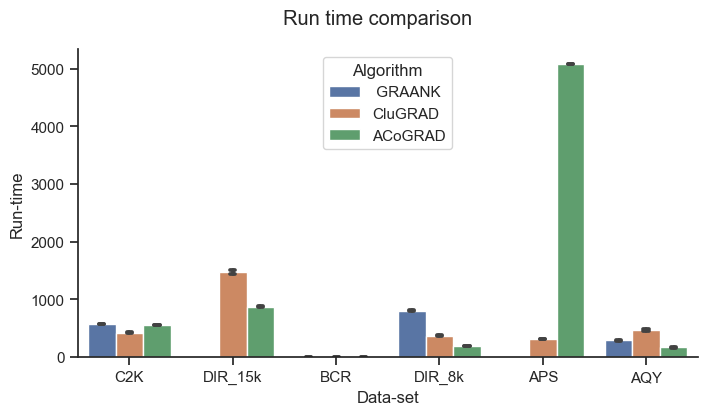

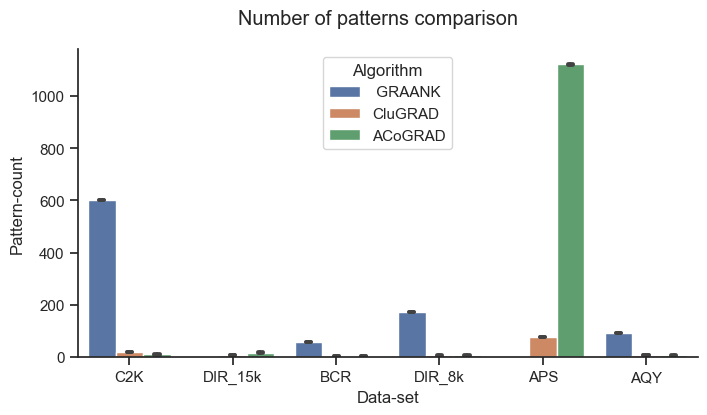

,Data-set,Algorithm,Run-time (mean),Run-time (std),Patterns (mean),Patterns (std)
0,BCR,ACoGRAD,0.089111,0.005890,5.111111,1.409584
1,BCR,CluGRAD,0.339500,0.154903,3.833333,1.403459
2,BCR,GRAANK,4.931000,0.451280,58.000000,0.000000
3,DIR_15k,ACoGRAD,876.643396,55.204593,16.245283,5.546675
4,DIR_15k,CluGRAD,1479.600000,68.380052,6.900000,1.209611
5,DIR_8k,ACoGRAD,194.016000,3.983579,6.600000,1.384437
6,DIR_8k,CluGRAD,374.364516,11.299072,6.225806,0.425024
7,DIR_8k,GRAANK,804.400000,70.432809,172.000000,0.000000
8,C2K,ACoGRAD,555.633333,6.380123,10.948718,3.060347
9,C2K,CluGRAD,425.511864,33.006646,19.813559,1.746668


In [18]:

# df_plot = df_res.drop(df_res[df_res['Data-set'] == 'BCR'].index).drop(df_res[df_res['Data-set'] == 'AQY'].index)
df_plot = df_res

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(8,4))
fig.suptitle('Run time comparison')
ax = sns.barplot(x="Data-set", y="Run-time", hue="Algorithm", data=df_plot, capsize=.05)

fig = plt.figure(figsize=(8,4))
fig.suptitle('Number of patterns comparison')
ax = sns.barplot(x="Data-set", y="Pattern-count", hue="Algorithm", data=df_plot, capsize=.05)

# bars = ax.patches
# pattern=['..','xx','*']

# replace 2 with 7 in your code
# hatches=np.repeat(pattern,2)
# for pat,bar in zip(hatches,bars):
#    bar.set_hatch(pat)
# ax.legend()

plt.show()
df_a


## 5.2. Memory Utilization Comparison

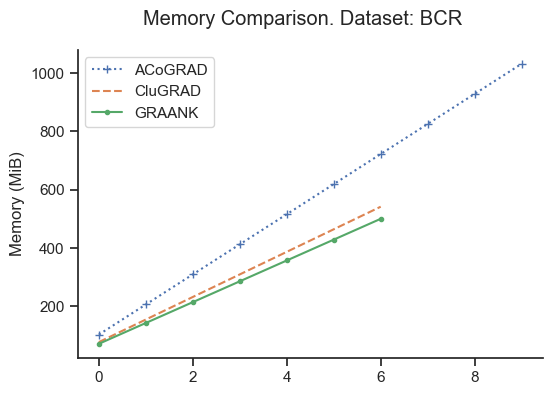

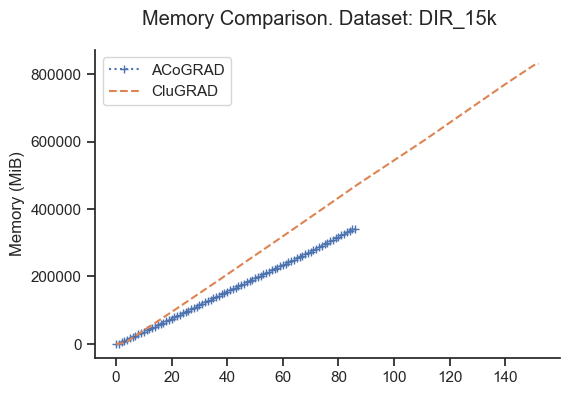

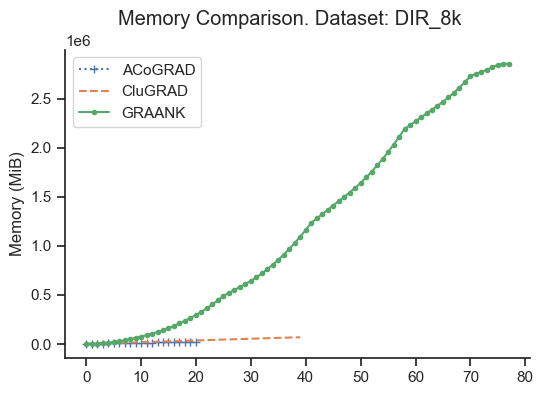

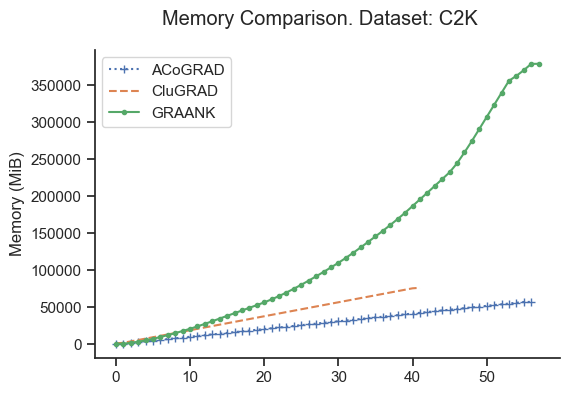

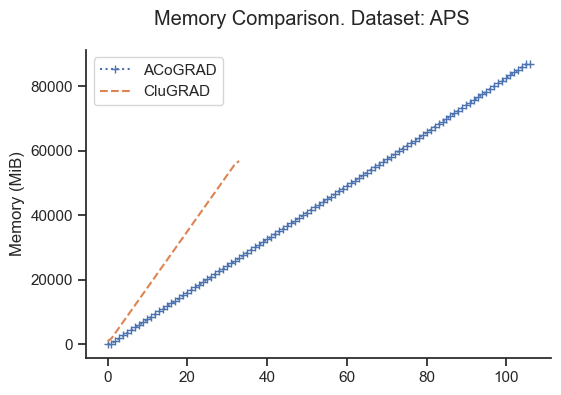

In [19]:

markers = ['+:', '--', '.-']
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

for ds in data_sets:
    df1 = df_b.loc[df_b['Data-set'] == ds]
                
    fig = plt.figure(figsize=(6,4))
    fig.suptitle('Memory Comparison. Dataset: ' + ds)
    plt.ylabel('Memory (MiB)')
    i = 0 # For markers
    
    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        
        mem = np.array(df2['Memory'])
        if mem.size > 0:
            mem = np.array(mem[0]).reshape(-1, 1)
            temp = np.random.randn(100,1)
            plt.plot(np.cumsum(mem), markers[i], label=alg)
            i += 1
            # plt.plot(mem, label=alg)
    plt.legend(loc="upper left")
#plt.show()


# 5. Extracted Gradual Patterns

These are the patterns extracted by the algorithms

In [20]:
data_sets = ['BCR', 'DIR', 'DIR_8k', 'C2K', 'AQY', 'APS']
algorithms = ['ACoGRAD', 'CluGRAD', 'GRAANK']


# Only include these columns
df_res = df_comp[["Data-set", "Algorithm", "Patterns"]]
# print(df_res)

data = []
for ds in data_sets:
    df1 = df_res.loc[df_res['Data-set'] == ds]
    
    print("\nDataset: " + str(ds))
    print("---------------\n")
    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        
        print("Algorithm: " + str(alg))
        print("Pattern: Support")
        
        for index,row in df2.iterrows():
            # print((row['Patterns'][1]))
            pat_str = (row['Patterns'])#.split('],')
            print(str(pat_str[0]) + ': ' + str(pat_str[1]))



Dataset: BCR
---------------

Algorithm: ACoGRAD
Pattern: Support
['6-', '4+'] : 0.528
['6-', '7+'] : 0.593
['2+', '7+'] : 0.52
['6-', '8+'] : 0.575
['6-', '8+'] : 0.575
['8-', '4-'] : 0.533
['6-', '7+'] : 0.593
['2+', '7+'] : 0.52
['8-', '3-'] : 0.536
['2+', '3+'] : 0.637
['6-', '8+'] : 0.575
['4+', '3+', '8+'] : 0.505
['4+', '3+', '1+'] : 0.583
['2+', '3+'] : 0.637
['8-', '2+'] : 0.505
['2+', '7+'] : 0.52
['5+', '7+'] : 0.548
['2+', '1+'] : 0.525
Algorithm: CluGRAD
Pattern: Support
['1+', '5+'] : 0.702
['1-', '5-'] : 0.656
['6-', '7+'] : 0.561
['1+', '8+'] : 0.568
['2-', '3-', '4-'] : 0.599
['3+', '4+', '5+'] : 0.552
['0+', '2+'] : 0.545
['1+', '5+'] : 0.707
['2-', '3-', '4-'] : 0.542
['3+', '4+'] : 0.847
['1+', '5+'] : 0.686
['1-', '5-'] : 0.692
Algorithm: GRAANK
Pattern: Support
['2+', '0+'] : 0.544
['4+', '0+'] : 0.507
['5+', '0+'] : 0.509
['6-', '0+'] : 0.539
['0+', '7-'] : 0.523
['8-', '0+'] : 0.513
['0-', '2-'] : 0.544
['0-', '4-'] : 0.507
['0-', '5-'] : 0.509
['0-', '6+'] : 0